# 3. Exploratory analysis of ERIC data on medical records spending

This takes the clean ERIC data we created in the previous notebook, and  does some basic exploratory analysis.

Findings: 

- Total spending on medical records is still going up - and is currently just under £250m a year, so on current trends, will be over a billion pounds in this Parliament.
- Spending is driven by some major outliers - there are over 200 active trusts, but the 10 top-spending trusts account for 23% of total spending - these include the renamed Northern Care Alliance NHS Foundation Trust, spending £9.4m a year, Barts, spending £8.7m a year, and Manchester University NHS Foundation Trust, spending £6.1m.
- We can normalise this by the number of patients in each trust's catchment area, which shows that Northern Care Alliance NHS Foundation Trust is even more of an outlier - it's spending £39/patient/year, while the next trust is spending £11/patient/year! This seems to be driven by very high onsite spending of over £6m/year since 2021/22.

Other exploratory findings:
- Aute trusts spend much more on medical records than any other kind, accounting for £230m of the £250m - probably not surprising.
- There doesn't seem to be a hugely strong relationship between total medical records spending and EPR type, including trusts that don't have an EPR - which is interesting. Richard suggests this implies that introducing an EPR doesn't have a big impact on spending on storage costs i.e. it suggests EPR contracts don't include digitisation of old records - to be investigated.

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

First define a reusable chart-drawing function.

In [8]:
def draw_chart(years, values_dict, title, xlabel, ylabel):
    plt.figure(figsize=(10, 6))
    x = np.arange(len(years))
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    bottoms = np.zeros(len(years))
    for i, (category, values) in enumerate(values_dict.items()):
        plt.bar(x, values, bottom=bottoms, label=category, color=colors[i % len(colors)])
        
        # Add value labels in the middle of each bar segment
        for j, value in enumerate(values):
            if value > 0:  # Only add label if there's a visible bar
                middle_pos = bottoms[j] + value/2
                plt.text(j, middle_pos, f'£{value:,.0f}', 
                        ha='center', va='center')
        bottoms += np.array(values)
    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
    plt.ylim(bottom=0)
    plt.xticks(x, years)
    
    plt.legend()
    plt.show()

# Examine total spending trends

Now, chart the total spent on onsite records storage by year for all trusts. We see that total spending is still going up.

In [11]:
df = pd.read_csv('./data/output/trust_mrc_and_epr.csv')

In [12]:
df.head()

,trust_code,trust_name,mrc_off_201718,mrc_off_201819,mrc_off_201920,mrc_off_202021,mrc_off_202122,mrc_off_202223,mrc_off_202324,mrc_on_201718,...,mrc_total_202122,mrc_total_202223,mrc_total_202324,current_name_in_foi,trust_type_from_foi,trust_epr,in_foi_data,all_admissions_22,emergency_admissions_22,mrc_total_202324_perpatient
0,RTQ,"2GETHER NHS FOUNDATION TRUST, GLOUCESTERSHIRE ...",34648.0,39826.0,39031.0,111500.0,111500.0,42500.0,64799.0,0.0,...,632233.0,588488.0,612164.0,GLOUCESTERSHIRE HEALTH AND CARE NHS FOUNDATION...,Mental Health and Community (Combined),TPP,True,NaN,NaN,NaN
1,REM,AINTREE UNIVERSITY HOSPITAL NHS FOUNDATION TRU...,65590.0,56657.0,58981.0,101922.0,1646581.0,1534829.0,1120134.0,69250.0,...,3293162.0,1679579.0,1120134.0,LIVERPOOL UNIVERSITY HOSPITALS NHS FOUNDATION ...,Acute,Dedalus Healthcare Ltd,True,705871.0,700130.0,1.59
2,RCF,AIREDALE NHS FOUNDATION TRUST,0.0,0.0,0.0,0.0,0.0,0.0,0.0,498051.0,...,554805.0,577884.0,715884.0,AIREDALE NHS FOUNDATION TRUST,Acute,TPP,True,188607.0,195373.0,3.80
3,RBS,ALDER HEY CHILDRENS NHS FOUNDATION TRUST,0.0,70.0,70.0,70.0,187744.0,548176.0,95580.0,71500.0,...,593662.0,977059.0,534275.0,ALDER HEY CHILDREN'S NHS FOUNDATION TRUST,Acute,Meditech Group Limited,True,NaN,NaN,NaN
4,RTK,ASHFORD AND ST. PETER'S HOSPITALS NHS FOUNDATI...,53010.0,53010.0,78692.0,92854.0,77554.0,172013.0,74413.0,1001766.0,...,900181.0,976980.0,764964.0,ASHFORD AND ST PETER'S HOSPITALS NHS FOUNDATIO...,Acute,Oracle Cerner Corporation,True,351397.0,351397.0,2.18


In [45]:
years = [x.split('_')[-1] for x in [col for col in df.columns if col.startswith('mrc_on')]]

In [61]:
for year in years:
    print(year, df['mrc_total_%s' % year].sum().astype(int))

201718 264338474
201819 231491788
201920 235491888
202021 225350299
202122 234250579
202223 237702259
202324 244655329


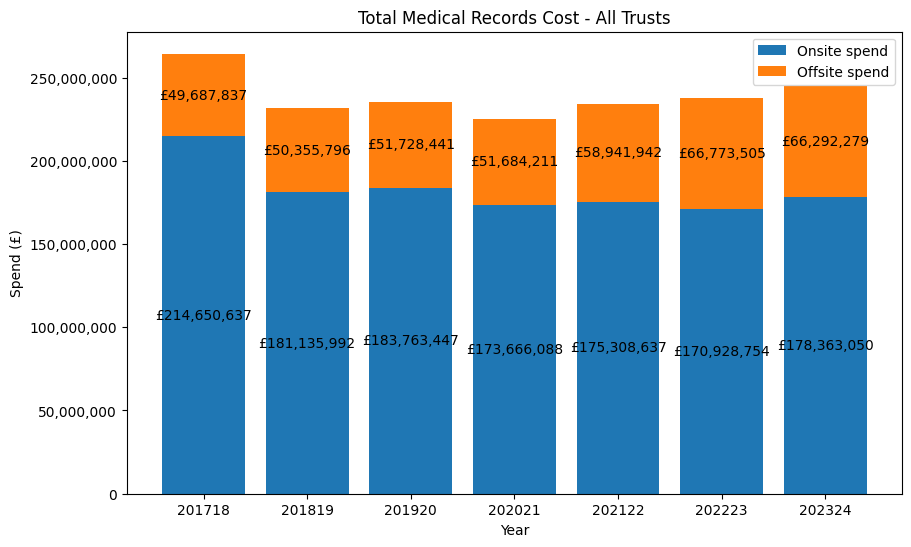

In [17]:
mrc_off_columns = [col for col in df.columns if col.startswith('mrc_off')]
mrc_on_columns = [col for col in df.columns if col.startswith('mrc_on')]
values_dict = {
  'Onsite spend':  df[mrc_on_columns].sum(), 
  'Offsite spend': df[mrc_off_columns].sum()
}
draw_chart(years, values_dict, f'Total Medical Records Cost - All Trusts', "Year", "Spend (£)")

### Break this down by trust type, and storage type

In [18]:
df.groupby('mrc_type_202324').sum()['mrc_total_202324']

mrc_type_202324
1. Paper            9694301.0
2. Electronic        846569.0
3. Mixed          234114459.0
Not Applicable            0.0
Name: mrc_total_202324, dtype: float64

In [19]:
df.groupby('mrc_service_provision_202324').sum()['mrc_total_202324']

mrc_service_provision_202324
External            5788652.0
Hybrid            117553064.0
Internal          117046034.0
Not Applicable            0.0
Other               4267579.0
Name: mrc_total_202324, dtype: float64

In [20]:
df.groupby(['mrc_type_202324', 'mrc_service_provision_202324']).sum()['mrc_total_202324']

mrc_type_202324  mrc_service_provision_202324
1. Paper         Hybrid                            6705569.0
                 Internal                          2988732.0
2. Electronic    External                           846569.0
                 Internal                                0.0
3. Mixed         External                          4942083.0
                 Hybrid                          110847495.0
                 Internal                        114057302.0
                 Other                             4267579.0
Not Applicable   Not Applicable                          0.0
Name: mrc_total_202324, dtype: float64

## Examine the impact of outliers

There are 234 trusts in the dataset, but the top 10 trusts account for nearly a quarter of overall spending.

In [48]:
top_trusts = df.sort_values(by='mrc_total_202324', ascending=False).head(10)
print(f"The top 10 trusts account for {top_trusts.mrc_total_202324.sum() / df.mrc_total_202324.sum() * 100:.1f}% of total spending")
# len(trust_df)

The top 10 trusts account for 22.8% of total spending


## Examine the top-spending trusts

Examine the 10 top-spending trusts, showing their trust type and EPR.

In [54]:
cols = ['current_name_in_foi', 'mrc_total_202324', 'mrc_total_202324_perpatient', 'all_admissions_22', 'trust_epr']
print("Top absolute spenders")
top_trusts[cols]

Top absolute spenders


,current_name_in_foi,mrc_total_202324,mrc_total_202324_perpatient,all_admissions_22,trust_epr
154,NORTHERN CARE ALLIANCE NHS FOUNDATION TRUST,"9,396,882",39,"239,042",Altera Digital Health
9,BARTS HEALTH NHS TRUST,"8,665,318",7,"1,173,479",Oracle Cerner Corporation
104,MANCHESTER UNIVERSITY NHS FOUNDATION TRUST,"6,081,336",4,"1,425,010",Epic Systems Corporation
222,UNIVERSITY HOSPITALS SUSSEX NHS FOUNDATION TRUST,"5,480,595",5,"1,012,289",Generic or In House EPR Provider
211,UNIVERSITY HOSPITALS OF DERBY AND BURTON NHS F...,"5,074,281",6,"843,151",Dedalus Healthcare Ltd
87,KING'S COLLEGE HOSPITAL NHS FOUNDATION TRUST,"4,591,272",7,"636,755",Epic Systems Corporation
175,MID AND SOUTH ESSEX NHS FOUNDATION TRUST,"4,420,479",4,"1,172,113",Dedalus Healthcare Ltd
159,SHEFFIELD TEACHING HOSPITALS NHS FOUNDATION TRUST,"4,210,874",7,"589,214",Dedalus Healthcare Ltd
207,UNIVERSITY HOSPITALS BIRMINGHAM NHS FOUNDATION...,"4,081,450",3,"1,320,003",Generic or In House EPR Provider
53,EAST KENT HOSPITALS UNIVERSITY NHS FOUNDATION ...,"3,857,212",5,"707,039",Altera Digital Health


Note that several of these seem to have started spending lots on offsite records in recent years - TODO investigate.

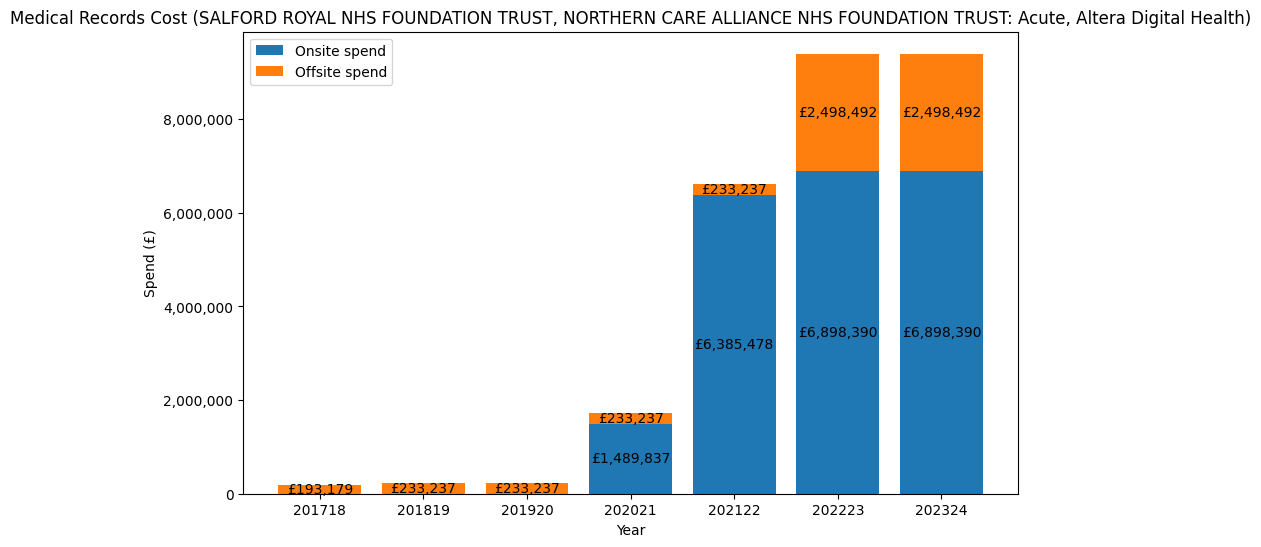

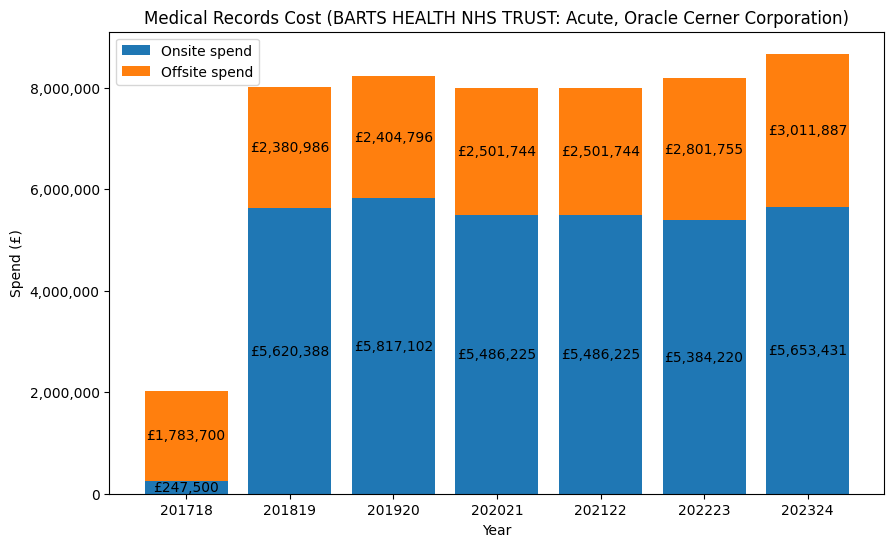

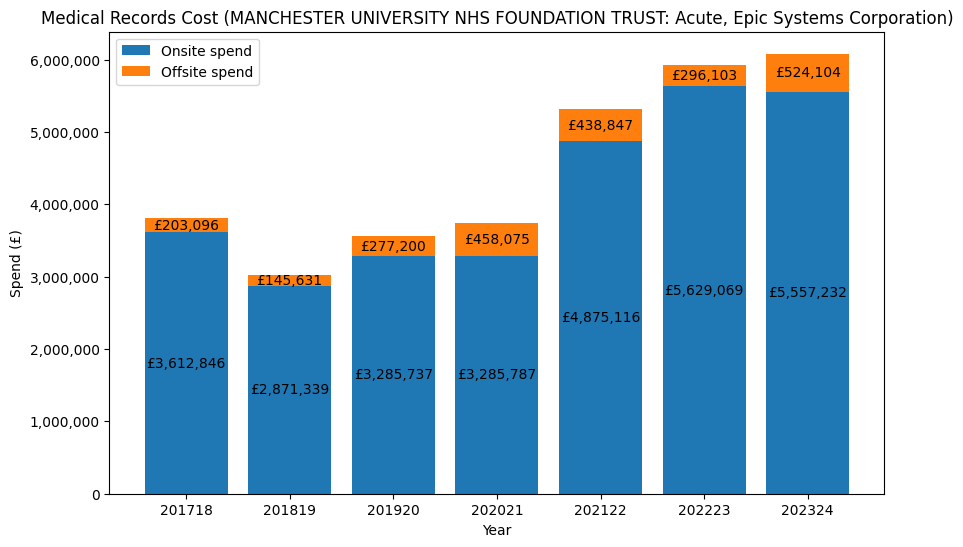

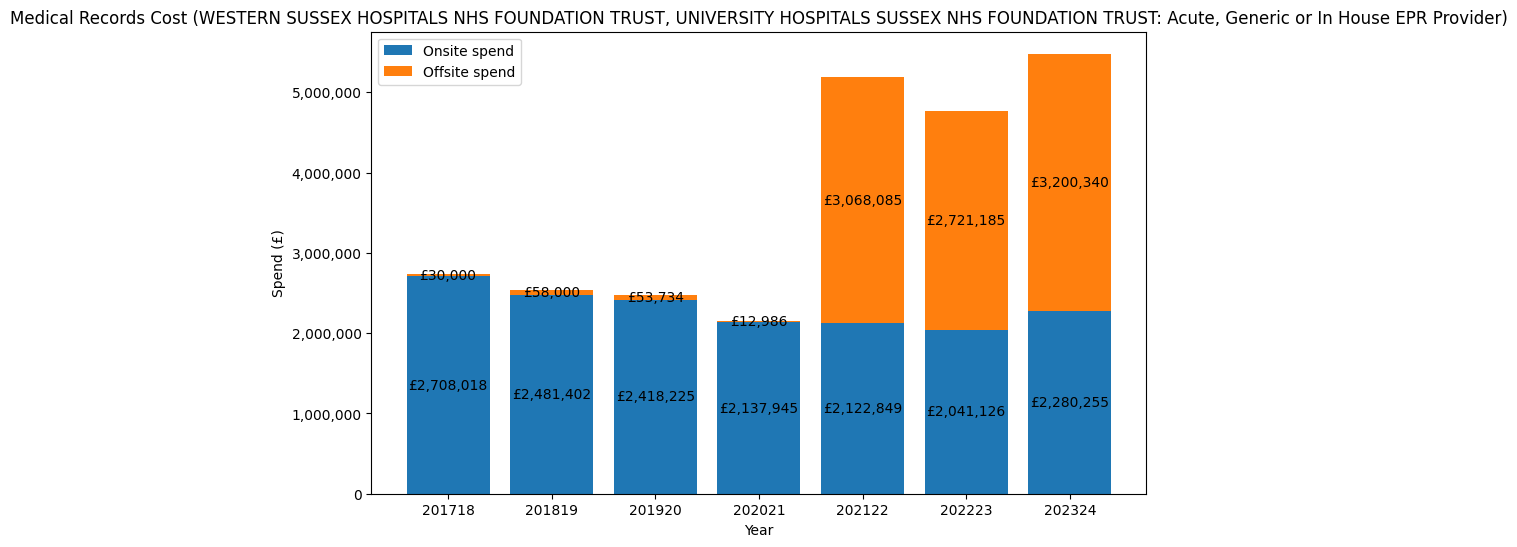

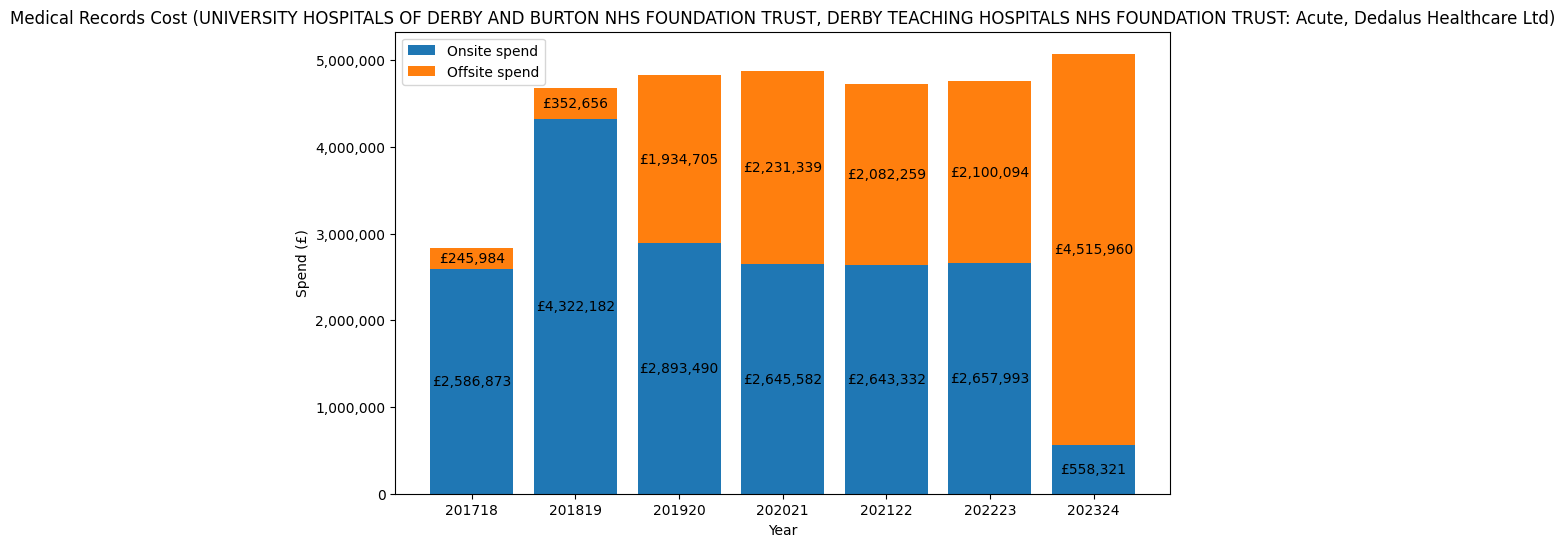

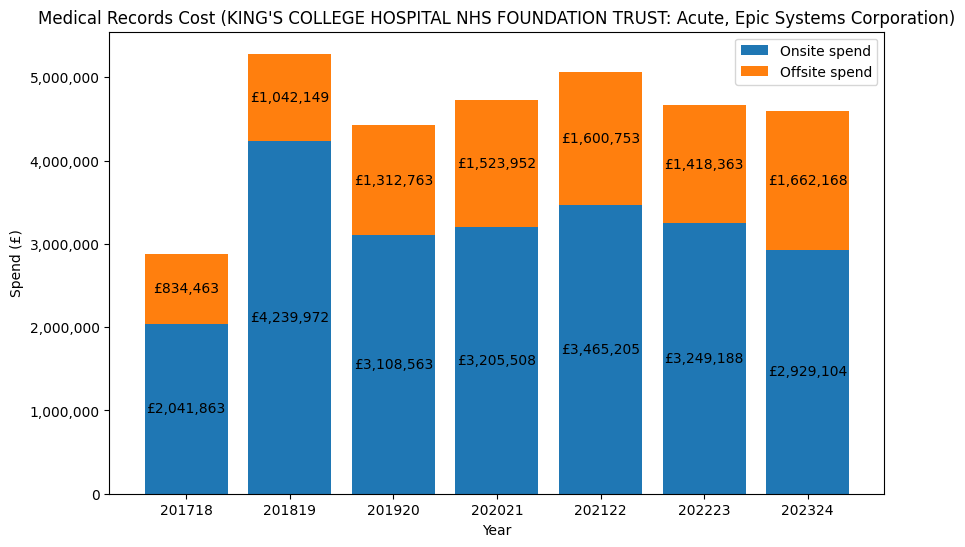

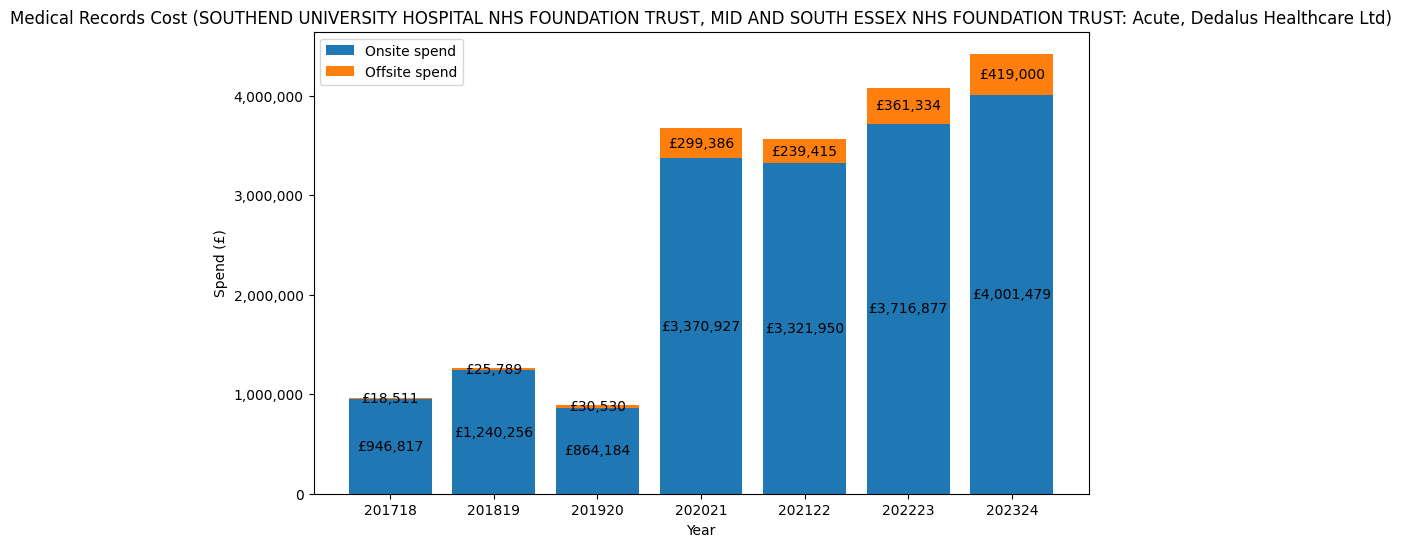

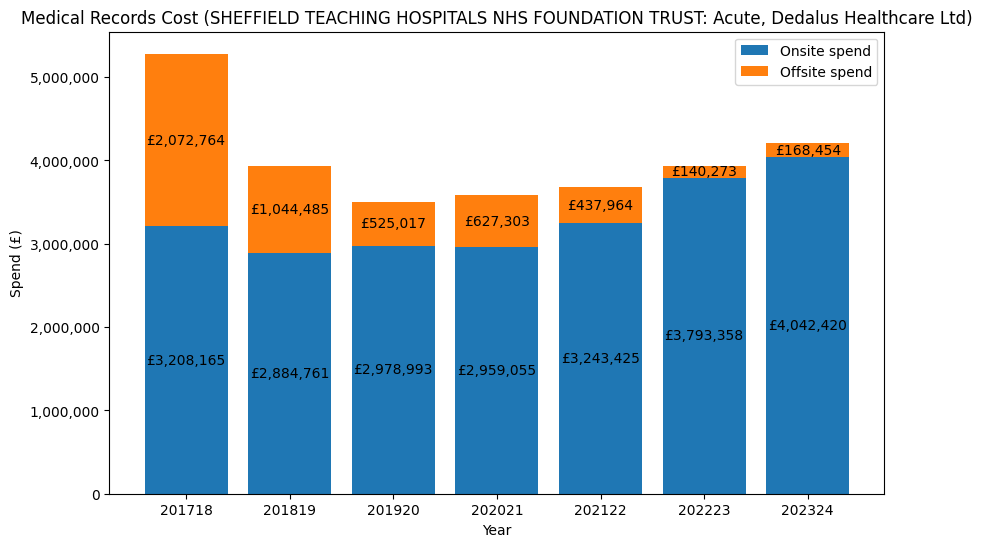

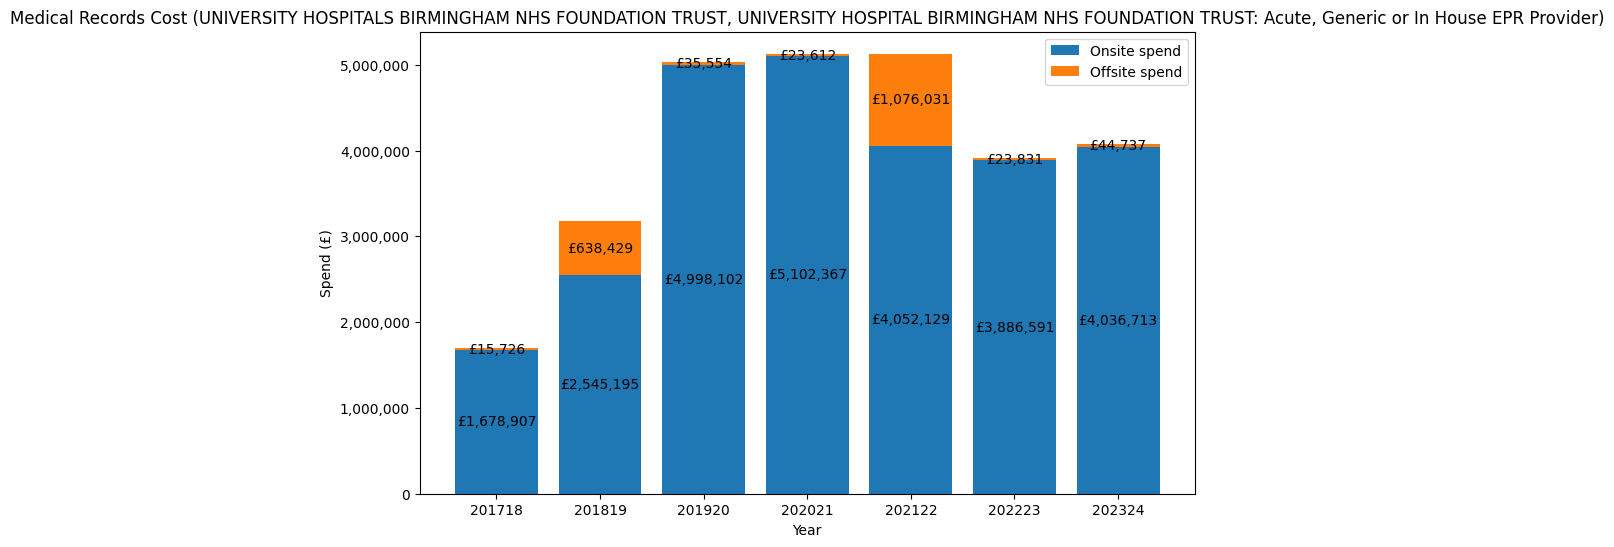

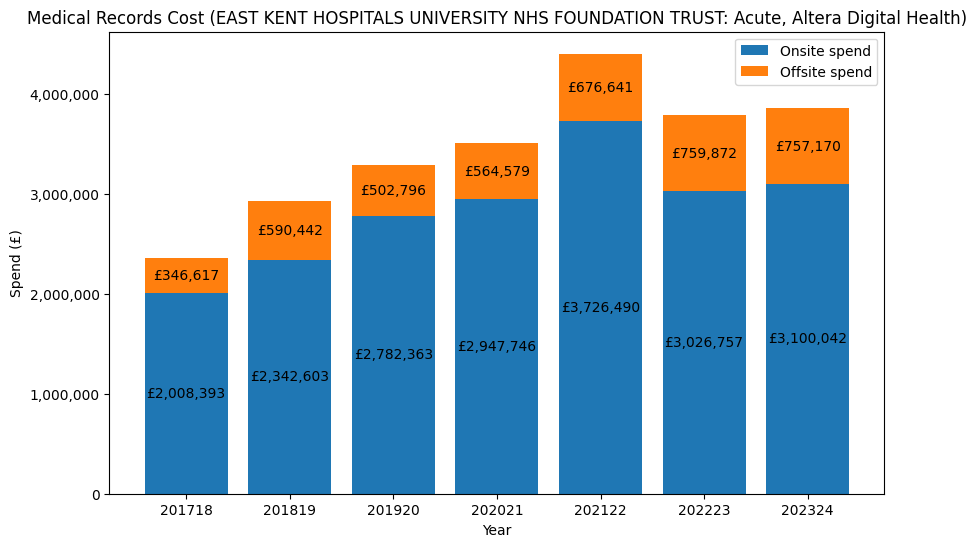

In [25]:
for index, row in top_trusts.iterrows():
  trust_name = row['trust_name']
  trust_type = row['trust_type_from_foi']
  trust_epr = row['trust_epr']
  values_dict = {
      'Onsite spend': [row[col] for col in mrc_on_columns], 
      'Offsite spend': [row[col] for col in mrc_off_columns],
  }
  years = [col.split('_')[-1] for col in mrc_on_columns]
  draw_chart(years, values_dict, f'Medical Records Cost ({trust_name}: {trust_type}, {trust_epr})', "Year", "Spend (£)")

### Examine top spenders normalised by population

Are the top spenders the same if we normalise by population?

Northern Care Alliance NHS Foundation Trust (formerly Salford Royal) was already top on absolute spending but now looks like even more of an outlier, it's spending £39 per person! 

In [55]:
print("Top spenders normalised per patient")
top_trusts_normalised = df.sort_values(by='mrc_total_202324_perpatient', ascending=False).head(10)
top_trusts_normalised[cols]

Top spenders normalised per patient


,current_name_in_foi,mrc_total_202324,mrc_total_202324_perpatient,all_admissions_22,trust_epr
154,NORTHERN CARE ALLIANCE NHS FOUNDATION TRUST,"9,396,882",39,"239,042",Altera Digital Health
17,BLACKPOOL TEACHING HOSPITALS NHS FOUNDATION TRUST,"3,440,960",11,"316,122",No EPR - in process of getting one
82,ISLE OF WIGHT NHS TRUST,"1,522,323",11,"142,296",CGI UK Ltd
202,TORBAY AND SOUTH DEVON NHS FOUNDATION TRUST,"2,421,116",9,"277,671",No EPR - in process of getting one
64,GEORGE ELIOT HOSPITAL NHS TRUST,"1,502,104",8,"177,636",Dedalus Healthcare Ltd
214,UNIVERSITY HOSPITALS PLYMOUTH NHS TRUST,"3,828,057",8,"452,631",No EPR - in process of getting one
51,EAST AND NORTH HERTFORDSHIRE NHS TRUST,"3,640,306",8,"440,583",Dedalus Healthcare Ltd
9,BARTS HEALTH NHS TRUST,"8,665,318",7,"1,173,479",Oracle Cerner Corporation
204,UNIVERSITY COLLEGE LONDON HOSPITALS NHS FOUNDA...,"1,989,597",7,"271,165",Epic Systems Corporation
87,KING'S COLLEGE HOSPITAL NHS FOUNDATION TRUST,"4,591,272",7,"636,755",Epic Systems Corporation


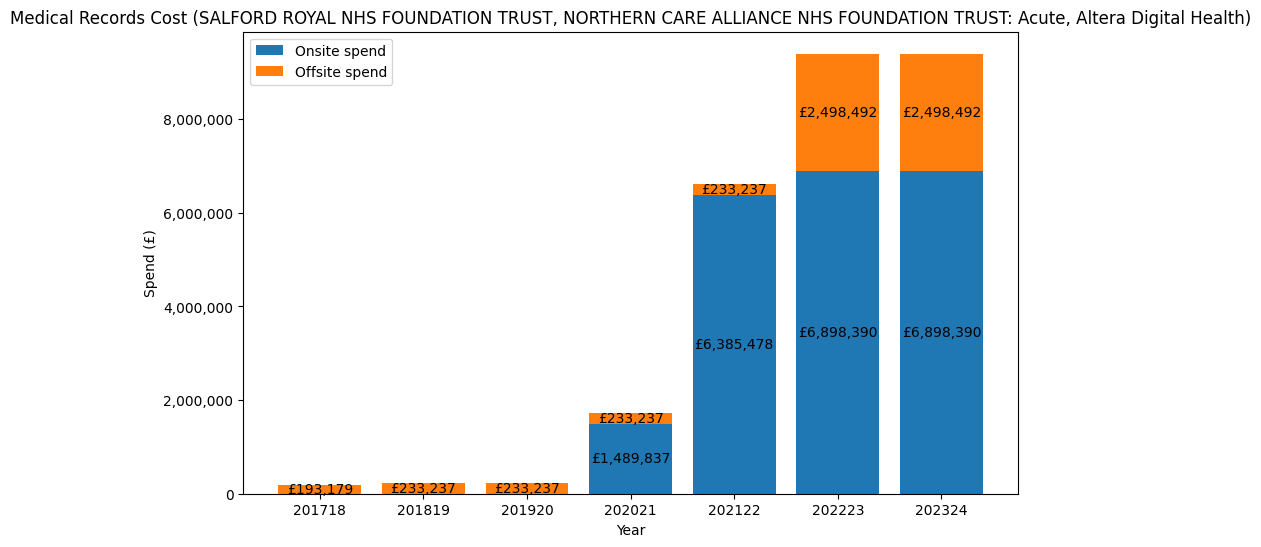

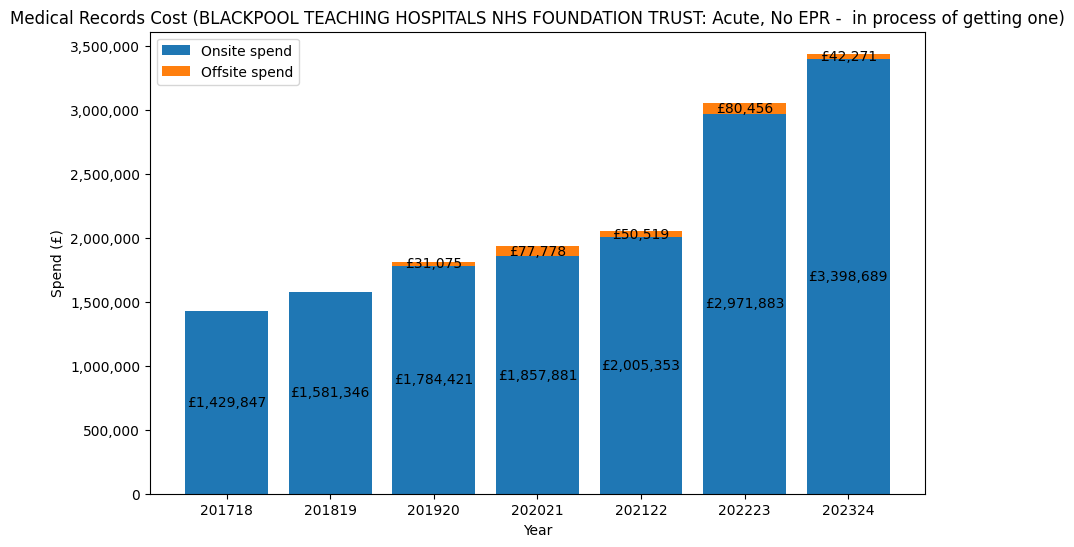

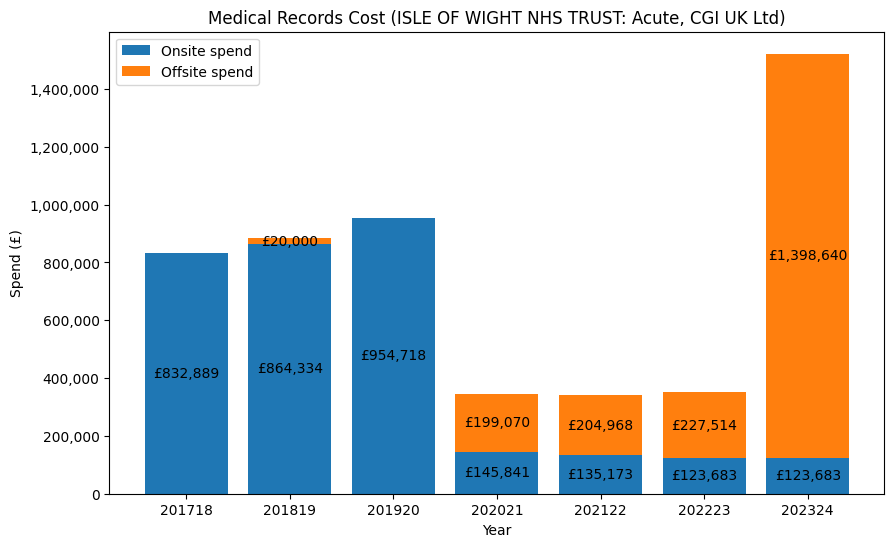

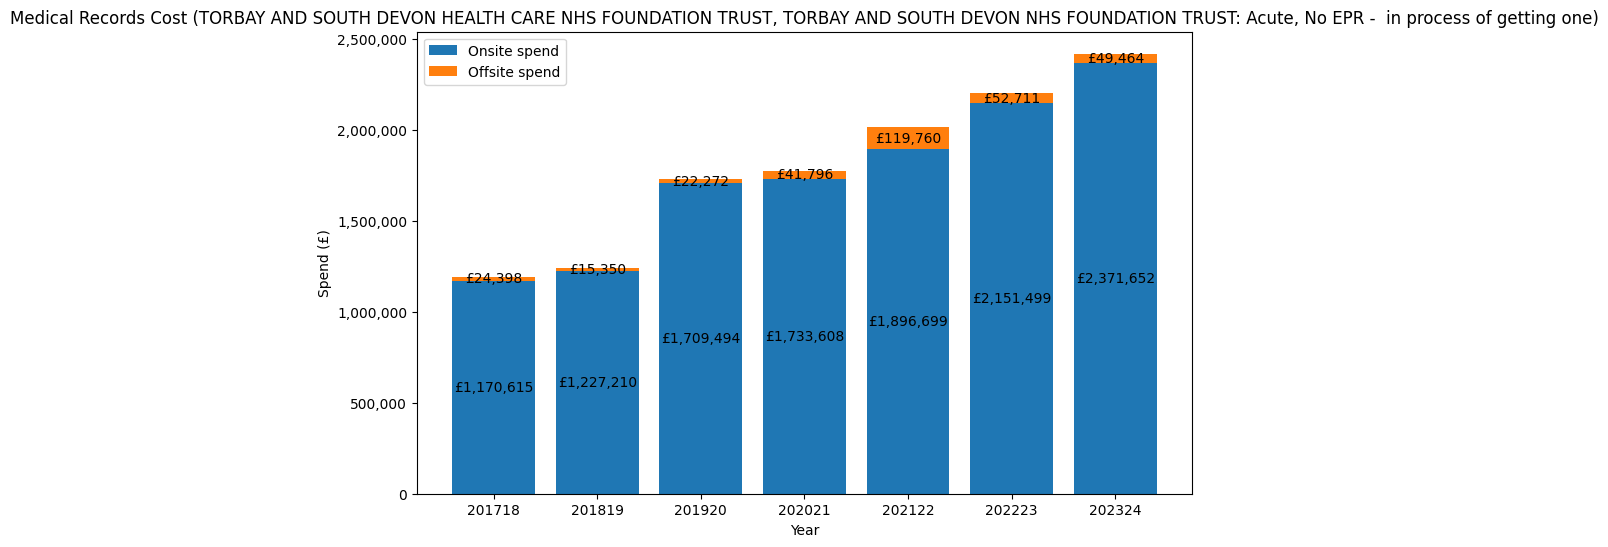

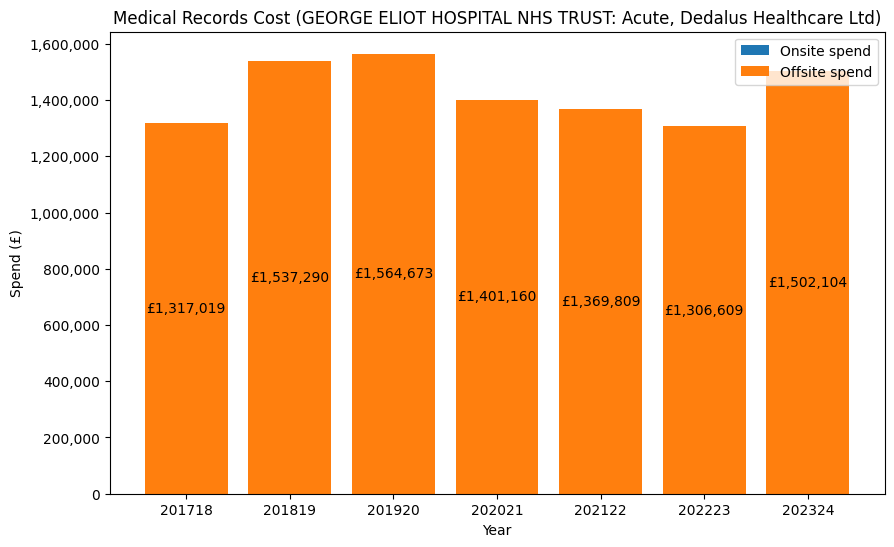

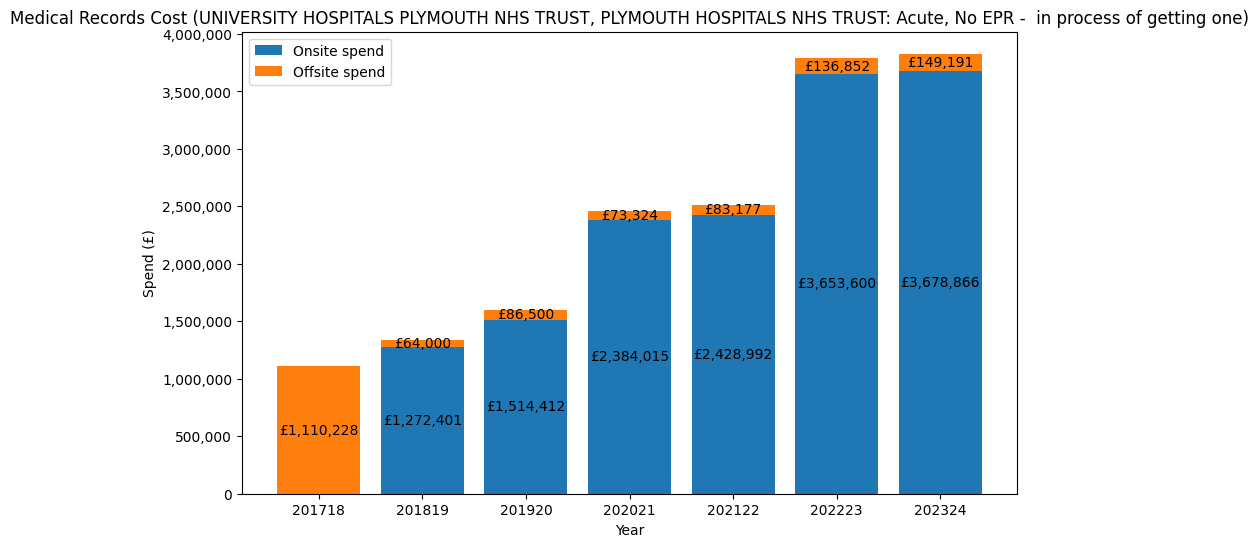

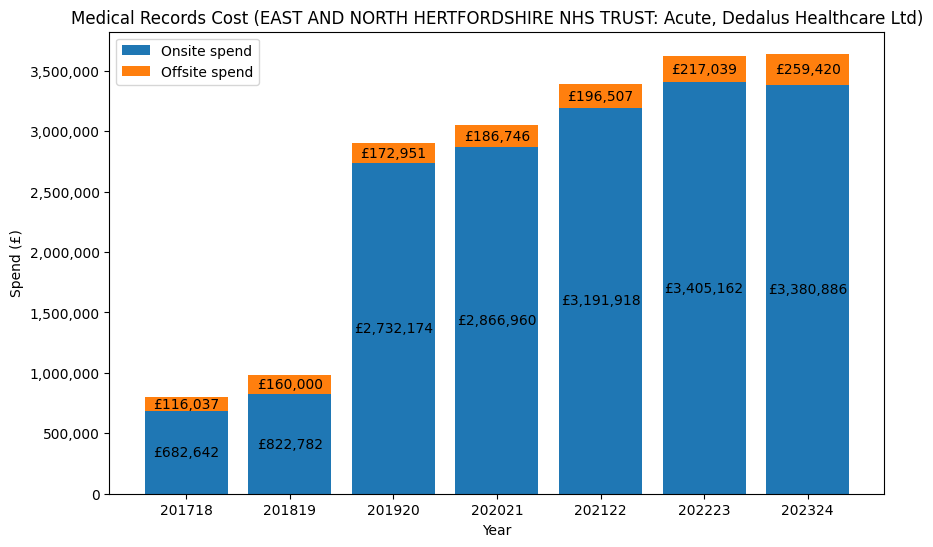

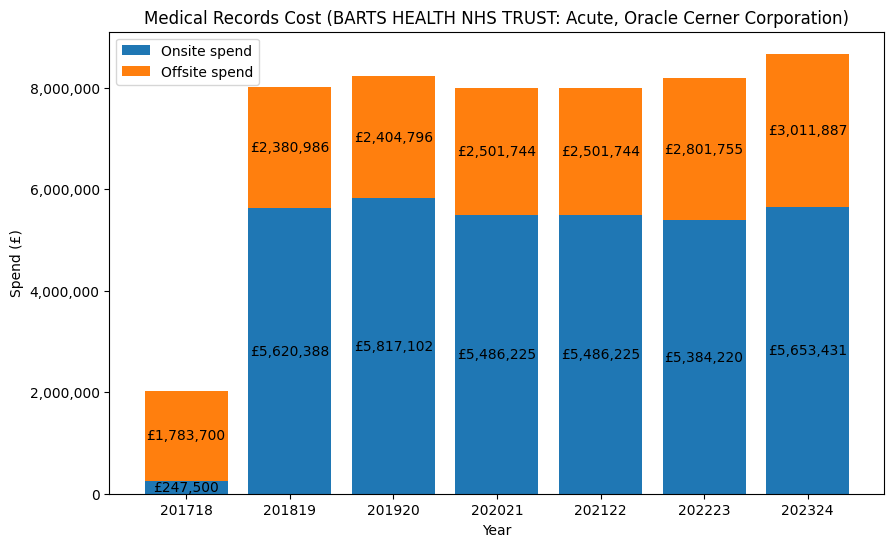

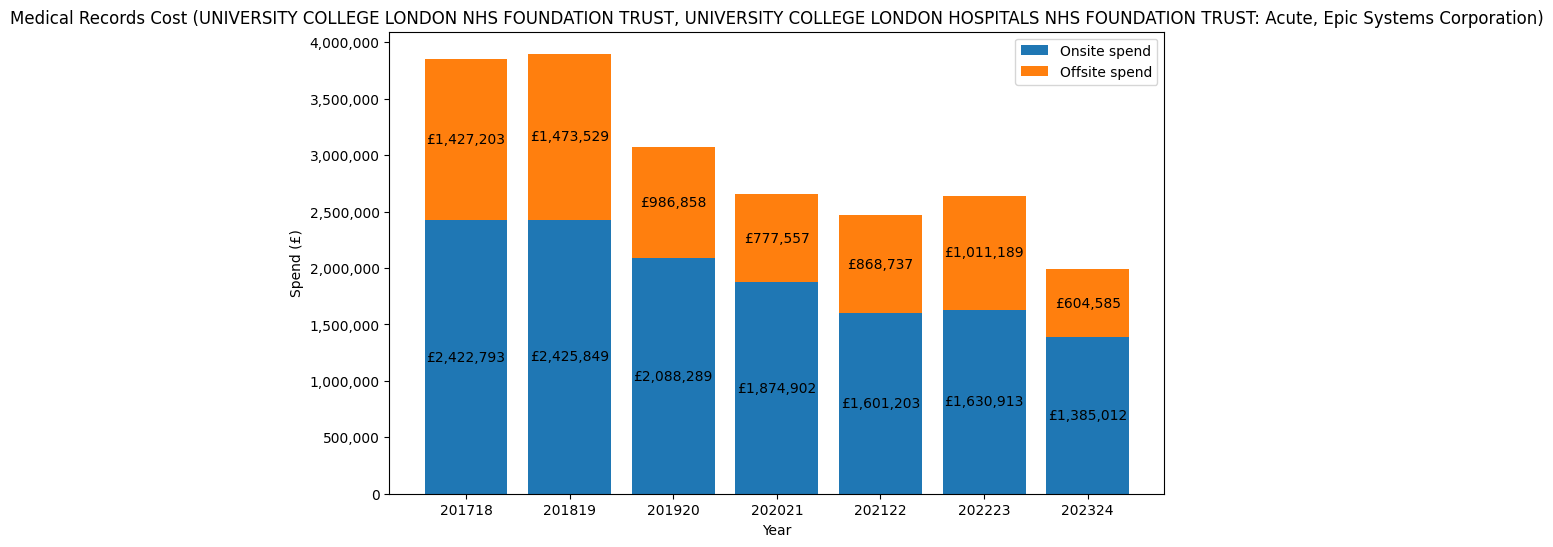

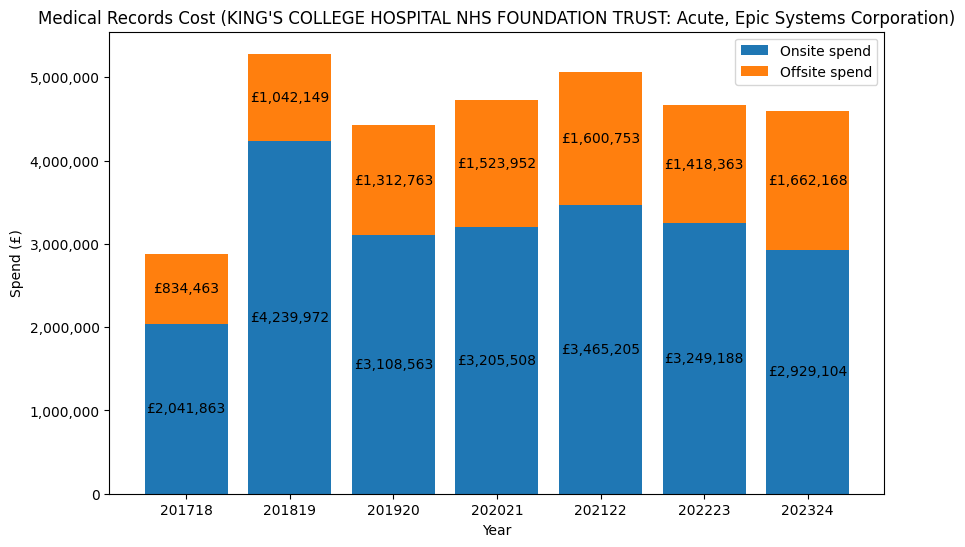

In [56]:
for index, row in top_trusts_normalised.iterrows():
  trust_name = row['trust_name']
  trust_type = row['trust_type_from_foi']
  trust_epr = row['trust_epr']
  values_dict = {
      'Onsite spend': [row[col] for col in mrc_on_columns], 
      'Offsite spend': [row[col] for col in mrc_off_columns],
  }
  years = [col.split('_')[-1] for col in mrc_on_columns]
  draw_chart(years, values_dict, f'Medical Records Cost ({trust_name}: {trust_type}, {trust_epr})', "Year", "Spend (£)")

# Examine spending by trust type

Perhaps there are differences in the spending by trust type? Yes, Acute trusts spend far more. 

Show the trend year-on-year.

In [31]:
print("Total spending by trust type 23/24")
df.groupby("trust_type_from_foi").mrc_total_202324.sum().sort_values(ascending=False).apply(lambda x: '{:,.0f}'.format(x))

Total spending by trust type 23/24


trust_type_from_foi
Acute                                     230,499,462
Mental Health and Community (Combined)      9,102,065
Mental Health                               3,148,996
Community                                   1,904,806
Ambulance                                           0
Name: mrc_total_202324, dtype: object

In [35]:
print("Mean spending by trust type 23/24")
df.groupby("trust_type_from_foi").mrc_total_202324.mean().sort_values(ascending=False).apply(lambda x: '{:,.0f}'.format(x))

Mean spending by trust type 23/24


trust_type_from_foi
Acute                                     1,707,403
Mental Health and Community (Combined)      275,820
Mental Health                               174,944
Community                                   146,524
Ambulance                                         0
Name: mrc_total_202324, dtype: object

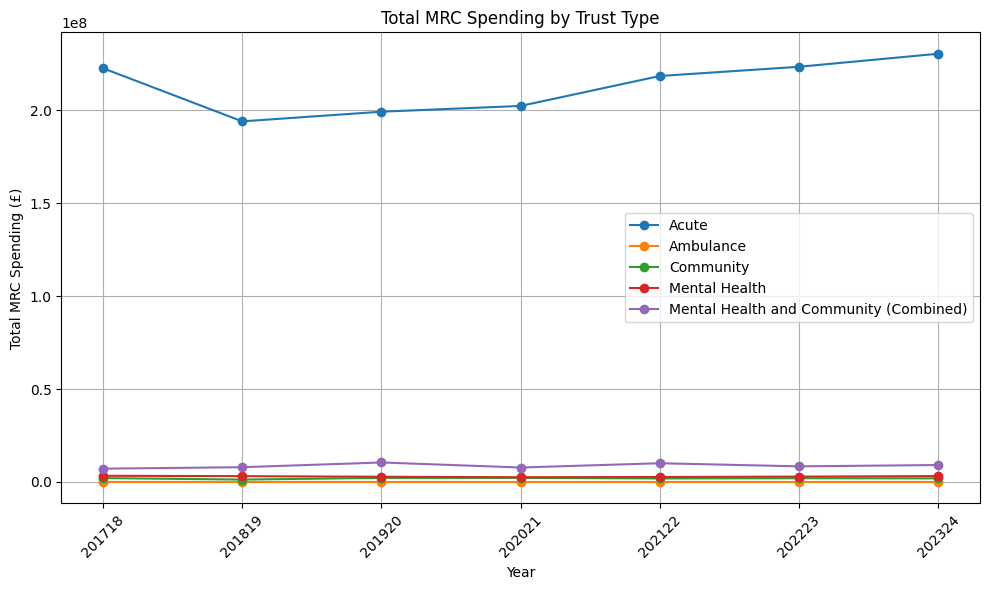

In [38]:
mrc_total_columns = [col for col in df.columns if col.startswith('mrc_total_')]
mrc_total_columns.remove("mrc_total_202324_perpatient")
plot_data = pd.DataFrame()
for col in mrc_total_columns:
   year = col[-6:]
   plot_data[year] = df.groupby('trust_type_from_foi')[col].sum()
plt.figure(figsize=(10,6))
for trust_type in plot_data.index:
    plt.plot(years, plot_data.loc[trust_type], marker='o', label=trust_type)
plt.xlabel('Year')
plt.ylabel('Total MRC Spending (£)')
plt.legend()
plt.xticks(rotation=45)
plt.title('Total MRC Spending by Trust Type')
plt.grid(True)
plt.tight_layout()

# Examine spending by EPR type

Perhaps there are differences in the spending by EPR supplier?

First, examine mean, median, total by EPR type. Altera is the EPR type with the highest mean spend, £2.5m mean. Others are pretty close behind.

TPP looks like an outlier on spend per patient, but that's just because it's used in lots of ambulance trusts and they don't have patient populations in our data, so ignore this. 

In [40]:
print("Spending per patient by trust type 23/24")
df.groupby("trust_type_from_foi").mrc_total_202324_perpatient.mean().sort_values(ascending=False).apply(lambda x: '{:,.0f}'.format(x))

Spending per patient by trust type 23/24


trust_type_from_foi
Acute                                       4
Ambulance                                 nan
Community                                 nan
Mental Health                             nan
Mental Health and Community (Combined)    nan
Name: mrc_total_202324_perpatient, dtype: object

In [41]:
pd.set_option('display.float_format', lambda x: '{:,.0f}'.format(x))
stats = pd.DataFrame({
   'Total spend': df.groupby("trust_epr").mrc_total_202324.sum(),
   'Mean spend by trust': df.groupby("trust_epr").mrc_total_202324.mean(),
   'Median spend by trust': df.groupby("trust_epr").mrc_total_202324.median(),
   'Number of trusts': df.groupby("trust_epr").mrc_total_202324.count(),
   'Total patients': df.groupby("trust_epr").all_admissions_22.sum(),
}).sort_values('Mean spend by trust', ascending=False)
stats['Mean spend per patient'] = stats['Total spend'] / stats['Total patients']
for col in ['Mean spend by trust', 'Total spend']:
   stats[col] = stats[col].apply(lambda x: '{:,.0f}'.format(x))
stats

,Total spend,Mean spend by trust,Median spend by trust,Number of trusts,Total patients,Mean spend per patient
trust_epr,,,,,,
Altera Digital Health,"25,724,396","2,572,440","1,773,340",10,"4,256,548",6
QuadraMed,"2,320,106","2,320,106","2,320,106",1,"386,021",6
Alcidion,"4,317,782","2,158,891","2,158,891",2,"741,693",6
Epic Systems Corporation,"18,473,783","2,052,643","1,108,033",9,"4,622,147",4
Dedalus Healthcare Ltd,"30,325,084","1,684,727","1,106,112",18,"6,222,340",5
No EPR - in process of getting one,"33,434,677","1,671,734","1,310,424",20,"5,874,134",6
Generic or In House EPR Provider,"26,396,556","1,649,785","1,161,182",16,"6,848,805",4
Oracle Cerner Corporation,"47,337,677","1,577,923","1,104,326",30,"14,410,816",3
Graphnet Health Ltd,"1,545,171","1,545,171","1,545,171",1,"574,181",3


However - we know that EPR suppliers vary a lot by trust type (from notebook 2), so let's examine acute trusts only.

In fact no one EPR seems to be associated with a huge difference in the cost of medical records. 

In [58]:
df_acute = df[df.trust_type_from_foi == 'Acute']
acute_stats = pd.DataFrame({
   'Total spend': df_acute.groupby("trust_epr").mrc_total_202324.sum(),
   'Mean spend by trust': df_acute.groupby("trust_epr").mrc_total_202324.mean(),
   'Median spend by trust': df_acute.groupby("trust_epr").mrc_total_202324.median(),
   'Number of trusts': df_acute.groupby("trust_epr").mrc_total_202324.count(),
   'Total patients': df.groupby("trust_epr").all_admissions_22.sum()
}).sort_values('Mean spend by trust', ascending=False)
acute_stats['Mean spend per patient'] = acute_stats['Total spend'] / acute_stats['Total patients']
acute_stats

,Total spend,Mean spend by trust,Median spend by trust,Number of trusts,Total patients,Mean spend per patient
trust_epr,,,,,,
Altera Digital Health,"25,724,396","2,572,440","1,773,340",10,"4,256,548",6
QuadraMed,"2,320,106","2,320,106","2,320,106",1,"386,021",6
Alcidion,"4,317,782","2,158,891","2,158,891",2,"741,693",6
Dedalus Healthcare Ltd,"29,793,300","2,128,093","1,521,511",14,"6,222,340",5
Epic Systems Corporation,"18,473,783","2,052,643","1,108,033",9,"4,622,147",4
Generic or In House EPR Provider,"26,396,556","1,759,770","1,344,699",15,"6,848,805",4
No EPR - in process of getting one,"33,434,677","1,671,734","1,310,424",20,"5,874,134",6
Oracle Cerner Corporation,"47,337,677","1,577,923","1,104,326",30,"14,410,816",3
Graphnet Health Ltd,"1,545,171","1,545,171","1,545,171",1,"574,181",3
